<div align="center" style="background-color:#fff3cd;
                           padding:12px 25px;
                           border-radius:10px;
                           border:1px solid #ffeeba;">
<h2>🌾 Harvest Classifier Project</h2>
<h4 style="color:#555;">Training Notebook</h4>
</div>

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

<div align="center" style="background-color:#fff3cd; padding:8px 15px; border-radius:8px; border:1px solid #ffeeba;">
<h3>🖼️ Image Transforms</h3>
</div>

In [53]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

<div align="center" style="background-color:#fff3cd; padding:8px 15px; border-radius:8px; border:1px solid #ffeeba;"> <h3>📂 Loading Data and Train Test Split</h3> </div> giev right icon

In [54]:
dataset_path = "./FreshHarvest_Dataset"
dataset = datasets.ImageFolder(dataset_path, transform=image_transforms)

In [55]:
len(dataset)

16000

In [86]:
len(dataset.classes)

16

In [112]:
dataset.classes

['F_Banana',
 'F_Lemon',
 'F_Lulo',
 'F_Mango',
 'F_Orange',
 'F_Strawberry',
 'F_Tamarillo',
 'F_Tomato',
 'S_Banana',
 'S_Lemon',
 'S_Lulo',
 'S_Mango',
 'S_Orange',
 'S_Strawberry',
 'S_Tamarillo',
 'S_Tomato']

In [62]:
num_classes = len(dataset.classes)

In [72]:
train_ratio = 0.75
val_ratio = 0.15
test_ratio = 0.10

In [73]:
len(dataset)

16000

In [74]:
train_size = int(train_ratio * (len(dataset)))
val_size = int(val_ratio * (len(dataset)))
test_size = int(test_ratio * (len(dataset)))

In [75]:
print(train_size, val_size, test_size)

12000 2400 1600


In [76]:
from torch.utils.data import random_split 

In [77]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) 

In [80]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)                       

In [81]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


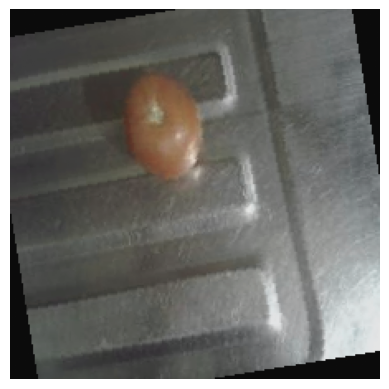

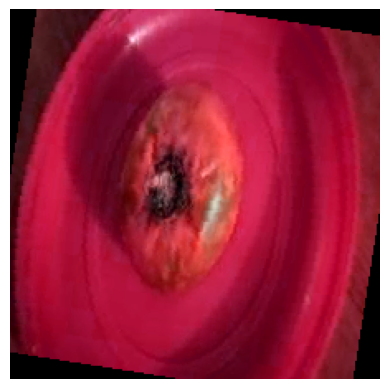

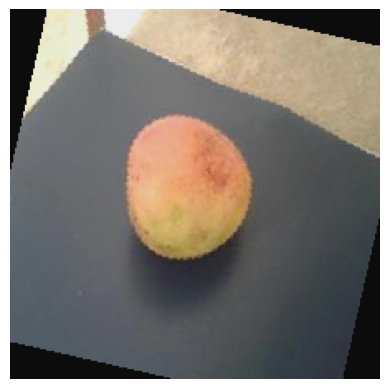

In [85]:
import matplotlib.pyplot as plt

# assume 'images' is a batch tensor of shape [B, C, H, W]
for i in range(3):
    img = images[i].permute(1, 2, 0)  # convert from (C,H,W) → (H,W,C)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # unnormalize
    img = torch.clamp(img, 0, 1)  # keep pixel values in [0,1]
    plt.imshow(img)
    plt.axis("off")
    plt.show()


<div align="center" style="background-color:#fff3cd; padding:8px 15px; border-radius:8px; border:1px solid #ffeeba;">
<h3>⚙️ Model Training Function</h3>
</div>

In [88]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

<div align="center" style="background-color:#fff3cd; padding:8px 15px; border-radius:8px; border:1px solid #ffeeba;">
<h3>🧠 HarvestClassifierCNN</h3>
</div>


In [87]:
class HarvestClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [89]:
model = HarvestClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 2.82
Batch: 20, Epoch: 1, Loss: 2.72
Batch: 30, Epoch: 1, Loss: 2.74
Batch: 40, Epoch: 1, Loss: 2.62
Batch: 50, Epoch: 1, Loss: 2.43
Batch: 60, Epoch: 1, Loss: 2.43
Batch: 70, Epoch: 1, Loss: 2.04
Batch: 80, Epoch: 1, Loss: 2.13
Batch: 90, Epoch: 1, Loss: 2.42
Batch: 100, Epoch: 1, Loss: 2.26
Batch: 110, Epoch: 1, Loss: 1.96
Batch: 120, Epoch: 1, Loss: 1.78
Batch: 130, Epoch: 1, Loss: 1.64
Batch: 140, Epoch: 1, Loss: 2.07
Batch: 150, Epoch: 1, Loss: 1.79
Batch: 160, Epoch: 1, Loss: 1.65
Batch: 170, Epoch: 1, Loss: 1.61
Batch: 180, Epoch: 1, Loss: 1.50
Batch: 190, Epoch: 1, Loss: 1.81
Batch: 200, Epoch: 1, Loss: 1.72
Batch: 210, Epoch: 1, Loss: 1.83
Batch: 220, Epoch: 1, Loss: 1.66
Batch: 230, Epoch: 1, Loss: 1.72
Batch: 240, Epoch: 1, Loss: 1.43
Batch: 250, Epoch: 1, Loss: 1.87
Batch: 260, Epoch: 1, Loss: 1.24
Batch: 270, Epoch: 1, Loss: 1.64
Batch: 280, Epoch: 1, Loss: 1.47
Batch: 290, Epoch: 1, Loss: 1.22
Batch: 300, Epoch: 1, Loss: 0.80
Batch: 310, Epoch: 

In [92]:
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
        
with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Test Accuracy: {100 * correct / total:.2f}% ***")

*** Test Accuracy: 93.06% ***


<div align="center" style="background-color:#fff3cd; padding:8px 15px; border-radius:8px; border:1px solid #ffeeba;">
<h3>🧠 HarvestClassifierCNNWithRegularization</h3>
</div>


In [93]:
class HarvestClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [94]:
model = HarvestClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 12.37
Batch: 20, Epoch: 1, Loss: 3.49
Batch: 30, Epoch: 1, Loss: 2.77
Batch: 40, Epoch: 1, Loss: 2.66
Batch: 50, Epoch: 1, Loss: 2.69
Batch: 60, Epoch: 1, Loss: 2.64
Batch: 70, Epoch: 1, Loss: 2.48
Batch: 80, Epoch: 1, Loss: 2.64
Batch: 90, Epoch: 1, Loss: 2.73
Batch: 100, Epoch: 1, Loss: 2.54
Batch: 110, Epoch: 1, Loss: 2.67
Batch: 120, Epoch: 1, Loss: 2.46
Batch: 130, Epoch: 1, Loss: 2.52
Batch: 140, Epoch: 1, Loss: 2.36
Batch: 150, Epoch: 1, Loss: 2.60
Batch: 160, Epoch: 1, Loss: 2.50
Batch: 170, Epoch: 1, Loss: 2.30
Batch: 180, Epoch: 1, Loss: 2.72
Batch: 190, Epoch: 1, Loss: 2.53
Batch: 200, Epoch: 1, Loss: 2.40
Batch: 210, Epoch: 1, Loss: 2.43
Batch: 220, Epoch: 1, Loss: 2.38
Batch: 230, Epoch: 1, Loss: 2.38
Batch: 240, Epoch: 1, Loss: 2.37
Batch: 250, Epoch: 1, Loss: 2.50
Batch: 260, Epoch: 1, Loss: 2.30
Batch: 270, Epoch: 1, Loss: 2.81
Batch: 280, Epoch: 1, Loss: 2.33
Batch: 290, Epoch: 1, Loss: 2.59
Batch: 300, Epoch: 1, Loss: 2.41
Batch: 310, Epoch:

In [95]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

<div align="center" style="background-color:#fff3cd; padding:8px 15px; border-radius:8px; border:1px solid #ffeeba;">
<h3>🧠 HarvestClassifierEfficientNet</h3>
</div>


In [96]:
class HarvestClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x      

In [97]:
model = HarvestClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 2.57
Batch: 20, Epoch: 1, Loss: 2.37
Batch: 30, Epoch: 1, Loss: 2.04
Batch: 40, Epoch: 1, Loss: 1.72
Batch: 50, Epoch: 1, Loss: 1.68
Batch: 60, Epoch: 1, Loss: 1.32
Batch: 70, Epoch: 1, Loss: 1.37
Batch: 80, Epoch: 1, Loss: 1.09
Batch: 90, Epoch: 1, Loss: 1.23
Batch: 100, Epoch: 1, Loss: 1.13
Batch: 110, Epoch: 1, Loss: 1.02
Batch: 120, Epoch: 1, Loss: 0.87
Batch: 130, Epoch: 1, Loss: 0.89
Batch: 140, Epoch: 1, Loss: 0.84
Batch: 150, Epoch: 1, Loss: 0.79
Batch: 160, Epoch: 1, Loss: 0.68
Batch: 170, Epoch: 1, Loss: 0.81
Batch: 180, Epoch: 1, Loss: 0.62
Batch: 190, Epoch: 1, Loss: 0.44
Batch: 200, Epoch: 1, Loss: 0.42
Batch: 210, Epoch: 1, Loss: 0.68
Batch: 220, Epoch: 1, Loss: 0.62
Batch: 230, Epoch: 1, Loss: 0.66
Batch: 240, Epoch: 1, Loss: 0.59
Batch: 250, Epoch: 1, Loss: 0.64
Batch: 260, Epoch: 1, Loss: 0.53
Batch: 270, Epoch: 1, Loss: 0.59
Batch: 280, Epoch: 1, Loss: 0.48
Batch: 290, Epoch: 1, Loss: 0.43
Batch: 300, Epoch: 1, Loss: 0.37
Batch: 310, Epoch: 

<div align="center" style="background-color:#fff3cd; padding:8px 15px; border-radius:8px; border:1px solid #ffeeba;">
<h3>🧠 HarvestClassifierResNet</h3>
</div>


In [98]:
# Load the pre-trained ResNet model
class HarvestClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [99]:
model = HarvestClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.82
Batch: 20, Epoch: 1, Loss: 0.50
Batch: 30, Epoch: 1, Loss: 0.46
Batch: 40, Epoch: 1, Loss: 0.32
Batch: 50, Epoch: 1, Loss: 0.18
Batch: 60, Epoch: 1, Loss: 0.33
Batch: 70, Epoch: 1, Loss: 0.42
Batch: 80, Epoch: 1, Loss: 0.28
Batch: 90, Epoch: 1, Loss: 0.13
Batch: 100, Epoch: 1, Loss: 0.24
Batch: 110, Epoch: 1, Loss: 0.24
Batch: 120, Epoch: 1, Loss: 0.11
Batch: 130, Epoch: 1, Loss: 0.15
Batch: 140, Epoch: 1, Loss: 0.06
Batch: 150, Epoch: 1, Loss: 0.05
Batch: 160, Epoch: 1, Loss: 0.04
Batch: 170, Epoch: 1, Loss: 0.05
Batch: 180, Epoch: 1, Loss: 0.22
Batch: 190, Epoch: 1, Loss: 0.06
Batch: 200, Epoch: 1, Loss: 0.04
Batch: 210, Epoch: 1, Loss: 0.03
Batch: 220, Epoch: 1, Loss: 0.15
Batch: 230, Epoch: 1, Loss: 0.01
Batch: 240, Epoch: 1, Loss: 0.04
Batch: 250, Epoch: 1, Loss: 0.17
Batch: 260, Epoch: 1, Loss: 0.13
Batch: 270, Epoch: 1, Loss: 0.18
Batch: 280, Epoch: 1, Loss: 0.01
Batch: 290, Epoch: 1, Loss: 0.29
Batch: 300, Epoch: 1, Loss: 0.02
Batch: 310, Epoch: 

<div align="center" style="background-color:#e3f2fd; padding:8px 15px; border-radius:8px; border:1px solid #90caf9;">
<h3>🚀 HarvestClassifierResNet (Using Tuned Hyperparameters)</h3>
</div>

**Used Parameters:**  
- Learning Rate (`lr`): `0.0001073294451814306`  
- Dropout Rate (`dropout_rate`): `0.6033590800832881`


In [101]:
model = HarvestClassifierResNet(num_classes=num_classes, dropout_rate=.6033590800832881).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001073294451814306)

labels, predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 2.70
Batch: 20, Epoch: 1, Loss: 2.62
Batch: 30, Epoch: 1, Loss: 2.49
Batch: 40, Epoch: 1, Loss: 2.17
Batch: 50, Epoch: 1, Loss: 1.76
Batch: 60, Epoch: 1, Loss: 1.37
Batch: 70, Epoch: 1, Loss: 1.05
Batch: 80, Epoch: 1, Loss: 0.76
Batch: 90, Epoch: 1, Loss: 0.61
Batch: 100, Epoch: 1, Loss: 0.35
Batch: 110, Epoch: 1, Loss: 0.24
Batch: 120, Epoch: 1, Loss: 0.18
Batch: 130, Epoch: 1, Loss: 0.13
Batch: 140, Epoch: 1, Loss: 0.20
Batch: 150, Epoch: 1, Loss: 0.09
Batch: 160, Epoch: 1, Loss: 0.18
Batch: 170, Epoch: 1, Loss: 0.10
Batch: 180, Epoch: 1, Loss: 0.08
Batch: 190, Epoch: 1, Loss: 0.09
Batch: 200, Epoch: 1, Loss: 0.09
Batch: 210, Epoch: 1, Loss: 0.05
Batch: 220, Epoch: 1, Loss: 0.07
Batch: 230, Epoch: 1, Loss: 0.05
Batch: 240, Epoch: 1, Loss: 0.14
Batch: 250, Epoch: 1, Loss: 0.07
Batch: 260, Epoch: 1, Loss: 0.14
Batch: 270, Epoch: 1, Loss: 0.04
Batch: 280, Epoch: 1, Loss: 0.14
Batch: 290, Epoch: 1, Loss: 0.03
Batch: 300, Epoch: 1, Loss: 0.11
Batch: 310, Epoch: 

<div align="center" style="background-color:#fff3cd; padding:8px 15px; border-radius:8px; border:1px solid #ffeeba;">
<h3>📊 Model Evaluation</h3>
</div>

In [105]:
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
        
with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Test Accuracy: {100 * correct / total:.2f}% ***")

*** Test Accuracy: 99.81% ***


In [107]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      0.98      0.99       112
           2       1.00      1.00      1.00       123
           3       1.00      1.00      1.00        95
           4       1.00      1.00      1.00        92
           5       0.99      1.00      1.00       109
           6       0.99      1.00      0.99        94
           7       1.00      1.00      1.00        93
           8       1.00      1.00      1.00       114
           9       1.00      1.00      1.00        96
          10       0.99      1.00      0.99        95
          11       1.00      1.00      1.00        91
          12       1.00      1.00      1.00        96
          13       1.00      0.99      0.99        93
          14       1.00      1.00      1.00        97
          15       1.00      1.00      1.00        86

    accuracy                           1.00      1600
   macro avg       1.00   

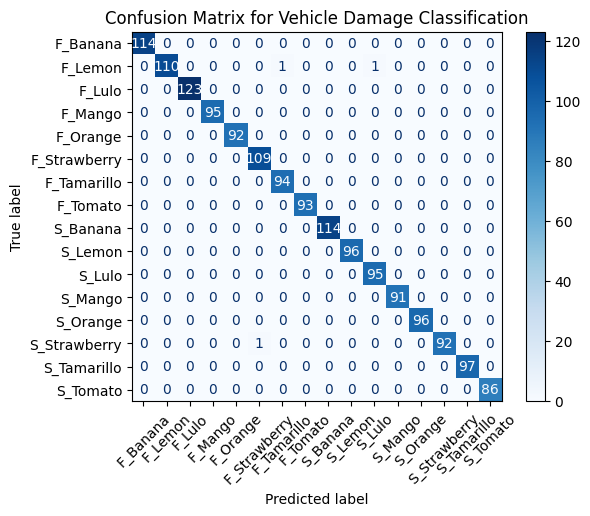

In [110]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

<div align="center" style="background-color:#fff3cd; padding:10px 20px; border-radius:10px; border:1px solid #ffeeba;">
<h3>💾 Model Saving</h3>
</div>


In [111]:
torch.save(model.state_dict(), 'saved_model.pth')